In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import config
import matplotlib.dates as dates
import sklearn.linear_model as linear_model
plt.rcParams.update({'font.size': 18})


In [44]:

def import_catalog(file):
    df = pd.read_csv(file)
    df.sort_values(by='first_arrival', inplace=True)
    df['arrival_datetime'] = df.arrival_time.apply(dates.num2date)
    return df
    
# also need to remove a number of columns that are simply irrelevant to the analysis or untested for a shareable dataset.

df141 = import_catalog(file='141precision.csv')
df188 = import_catalog(file='188precision.csv')
df197 = import_catalog(file='197precision.csv')
df211 = import_catalog(file='211precision.csv')


columns_to_keep = ['id', 'depth', 'relative_depth',
        'first_hydrophone', 'second_hydrophone',
       'arrival_time', 'first_arrival', 'second_arrival', 'dt',
       'max_amp', 'cum_amp', 'arrival_datetime', 'origin_time']

df141 = df141[columns_to_keep].copy()
df188 = df188[columns_to_keep].copy()
df197 = df197[columns_to_keep].copy()
df211 = df211[columns_to_keep].copy()

df141.sort_values(by='arrival_datetime', inplace=True)
df188.sort_values(by='arrival_datetime', inplace=True)
df197.sort_values(by='arrival_datetime', inplace=True)
df211.sort_values(by='arrival_datetime', inplace=True)

# # removing the events with maximum amplitude <0.1 since they are false positives
df141 = df141[df141.max_amp > 0.5].copy()
df188 = df188[df188.max_amp > 0.5].copy()
df197 = df197[df197.max_amp > 0.5].copy()
df211 = df211[df211.max_amp > 0.5].copy()

df141.drop_duplicates(subset=['arrival_datetime',], inplace=True)
df188.drop_duplicates(subset=['arrival_datetime',], inplace=True)
df197.drop_duplicates(subset=['arrival_datetime',], inplace=True)
df211.drop_duplicates(subset=['arrival_datetime',], inplace=True)

df141 = df141[df141.depth > 160].copy()
df188 = df188[df188.depth > 160].copy()
df197 = df197[df197.depth > 160].copy()
df211 = df211[df211.depth > 160].copy()

df141['origin_time'] = pd.to_datetime(df141['origin_time'])
df188['origin_time'] = pd.to_datetime(df188['origin_time'])
df197['origin_time'] = pd.to_datetime(df197['origin_time'])
df211['origin_time'] = pd.to_datetime(df211['origin_time'])

columns_to_keep = ['depth', 'first_hydrophone',
       'second_hydrophone', 'origin_time']

df141 = df141[columns_to_keep]
df188 = df188[columns_to_keep]
df197 = df197[columns_to_keep]
df211 = df211[columns_to_keep]

# Calculates the difference of a DataFrame element compared with another element in the DataFrame (default is element in previous row).
df141['dz'] = df141['depth'].diff()
df188['dz'] = df188['depth'].diff()
df197['dz'] = df197['depth'].diff()
df211['dz'] = df211['depth'].diff()

df141['dt'] = df141.origin_time.diff().apply(lambda t: t.total_seconds())
df188['dt'] = df188.origin_time.diff().apply(lambda t: t.total_seconds())
df197['dt'] = df197.origin_time.diff().apply(lambda t: t.total_seconds())
df211['dt'] = df211.origin_time.diff().apply(lambda t: t.total_seconds())

df141['ts'] = df141.dt.fillna(0).cumsum()
df188['ts'] = df188.dt.fillna(0).cumsum()
df197['ts'] = df197.dt.fillna(0).cumsum()
df211['ts'] = df211.dt.fillna(0).cumsum()

<Axes: >

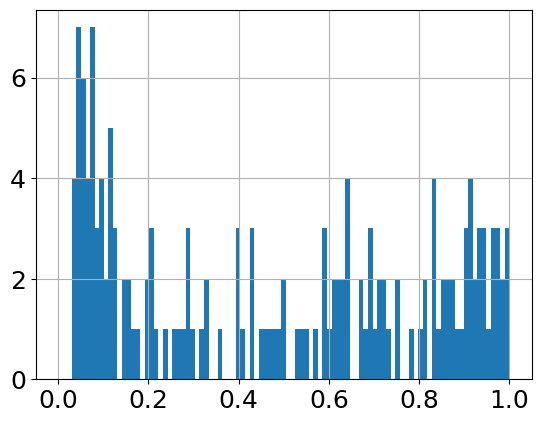

In [190]:
def sign(number):
    if number > 0:
        return 'blue'
    elif number == 0:
        return 'darkorange'
    else:
        return 'red'

df141['sign'] = df141.dz.apply(sign)
df141['d+'] = df141.dz.apply(sign).apply(lambda s: 1 if s=='blue' else 0)
df141['d-'] = df141.dz.apply(sign).apply(lambda s: 1 if s=='red' else 0)
df141['d0'] = df141.dz.apply(sign).apply(lambda s: 1 if s=='darkorange' else 0)
df141['dz/dt'] = df141['dz']/df141['dt']
df141[df141['d+']==1]['dz/dt'].hist(bins=np.linspace(0, 1, 100))

<Axes: xlabel='ts'>

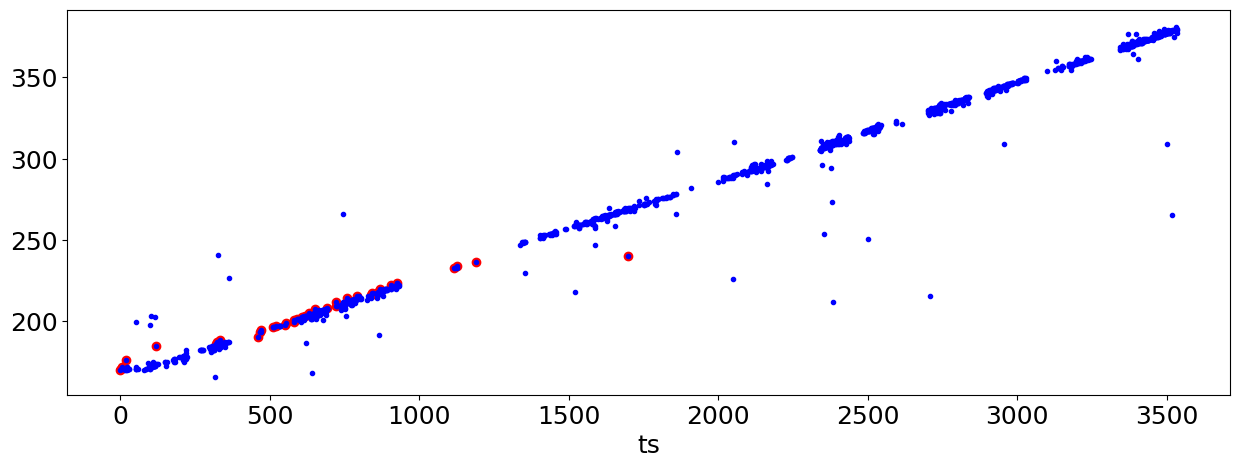

In [265]:
df141['dz+'] = df141[df141['d+']==1].depth.diff()
df141['dt+'] = df141[df141['d+']==1].origin_time.diff().apply(lambda t: t.total_seconds())
df141['v+'] = df141['dz+']/df141['dt+']
# fig, ax = plt.subplots(figsize=(15, 5))
# df141[df141['d+']==1].set_index('ts')['v+'].plot(ax=ax)

df141[(df141['d+']==1) & (df141['dz+']>=0)]['v+'].mean()
# df141[(df141['d+']==1)]['v+'].mean()
# df141[(df141['d+']==1) & (df141['d+']>0)].plot.scatter('ts', 'depth')

'''
For each catalog with N events, each (i-th) event is characterized by a source depth, zi, and origin time, ti (and amplitude but we won't use that here).
Code up the following where vi = instantaneous velocity at event time ti.

NOTE: remember that Rob uses matlab which is indexed from 1

zmax=z1
tmax=t1
for i = 2:N
  if zi > zmax
    vi = (zi- zmax)/(ti - tmax)
    zmax=zi
    tmax=ti
  end
end
'''

depths = df141.depth.values
times = df141.ts.values

zmax = depths[0]
tmax = times[0]

zdeep = [1]

for i in np.arange(0, df141.shape[0], 1)[1:]:
    # print('wat')
    if depths[i] - zmax > 10:
        zdeep.append(0)
        tmax = times[i]
        # print(depths[i] - zmax)
        
    elif depths[i] > zmax:
        zdeep.append(1)
        zmax = depths[i]
        tmax = times[i]
        
    else:
        # print('no')
        zdeep.append(0)

df141['deepest'] = zdeep


fig, ax = plt.subplots(figsize=(15, 5))
df141[df141.deepest==1].set_index('ts').depth.plot(color='red', marker='o', linestyle='')
df141.set_index('ts').depth.plot(color='blue', marker='.', linestyle='')

Text(0.5, 1.0, 'Day 141')

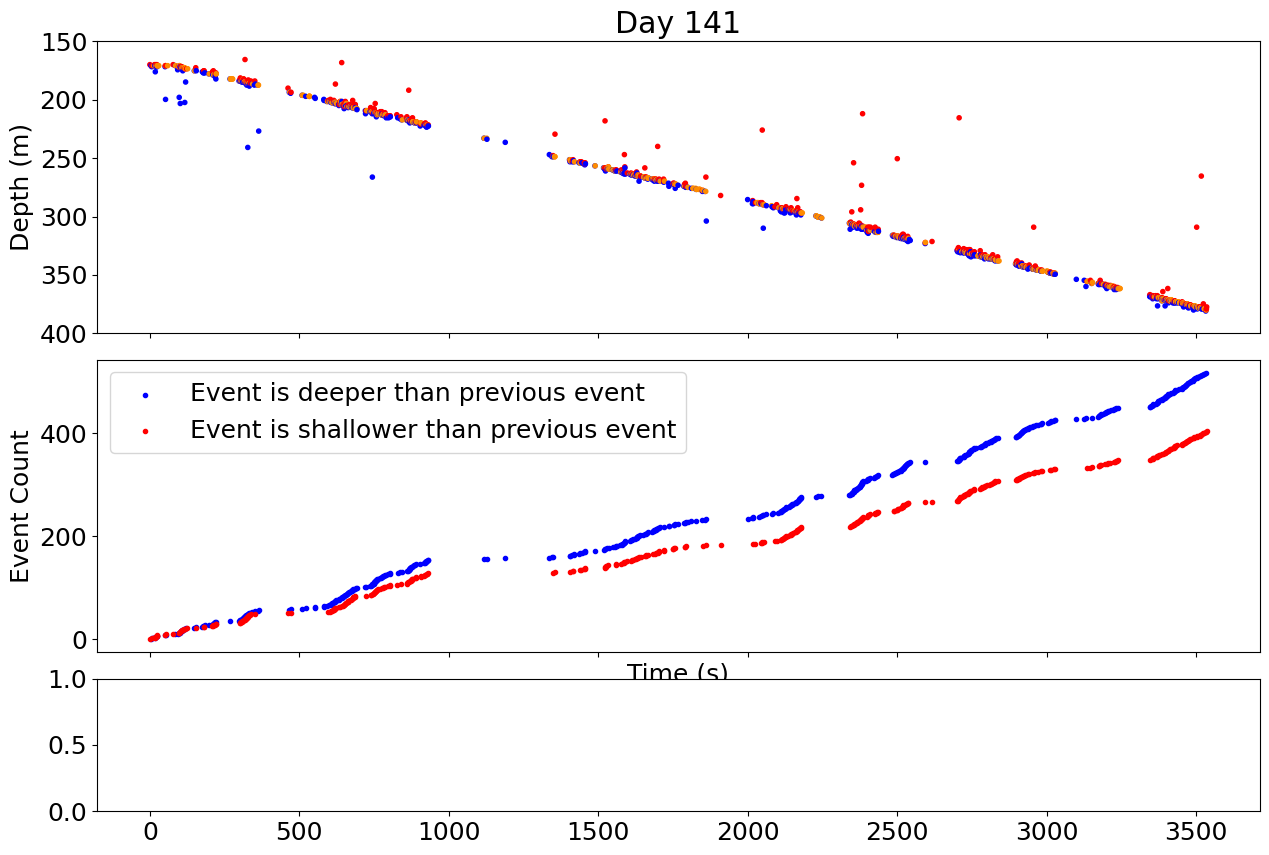

In [189]:
# fig, ax = plt.subplots(2, 1, figsize=(15, 5), sharex=True)
fig = plt.figure(figsize=(15, 10))
ax = fig.subplot_mosaic('''
                            aaaaa
                            aaaaa
                            bbbbb
                            bbbbb
                            ccccc
                            '''
                           ,sharex=True)
fig.subplots_adjust(wspace=0)

data = df141.copy()
ax['a'].set_ylim(400, 150)
ax['a'].set_ylabel('Depth (m)')
ax['b'].set_ylabel('Event Count')
ax['b'].set_xlabel('Time (s)')

ax['a'].scatter(data.ts.values, data.depth.values, color=data.dz.apply(sign), marker='.')

ax['b'].scatter(data[data['d+']==1].ts, data[data['d+']==1]['d+'].cumsum(), marker='.', color='blue', label='Event is deeper than previous event')
ax['b'].scatter(data[data['d-']==1].ts, data[data['d-']==1]['d-'].cumsum(), marker='.', color='red', label='Event is shallower than previous event')
# ax['b'].scatter(data[data['d0']==1].ts, data[data['d0']==1]['d-'].cumsum(), marker='.', color='darkorange', label='Event is shallower than previous event')
ax['b'].legend()
ax['a'].set_title('Day 141')

In [182]:
# data = df141.copy()

# t = data.ts.values
# d = data.depth.values

# fig, ax = plt.subplots(figsize=(15, 15))
# ax.set_ylim(400, 150)
# ax.set_ylabel('Depth (m)')
# ax.set_xlabel('Time (s)')


# def sign(number):
#     if number >=0:
#         return 'blue'
#     else:
#         return 'red'


# ax.scatter(data.ts.values, data.depth.values, color=data.dz.apply(sign), marker='.')

# data['d+'] = data.dz.apply(sign).apply(lambda s: 1 if s=='blue' else 0)
# data['d-'] = data.dz.apply(sign).apply(lambda s: 1 if s=='red' else 0)

# fig, ax = plt.subplots(figsize=(15, 5))
# ax.scatter(data.ts, data['d+'].cumsum())
# ax.scatter(data.ts, data['d-'].cumsum())

<Axes: >

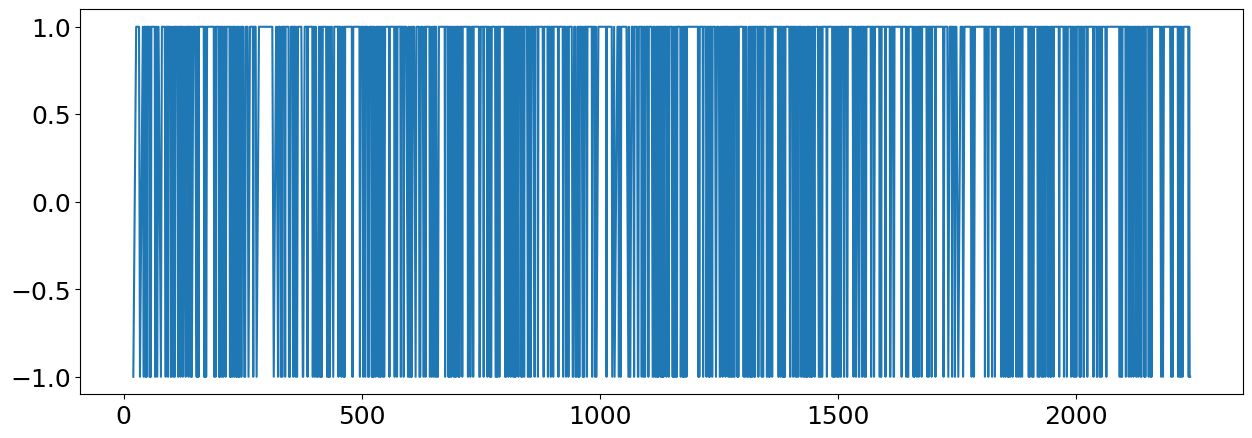

In [25]:
def sign(number):
    if number >= 0:
        return 1
    else:
        return -1

df141.dz.apply(sign).plot(figsize=(15,5))